<a href="https://colab.research.google.com/github/sedanurozer/cifar10/blob/main/tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from PIL import Image
from keras.layers import BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import os
import warnings
import pickle
from tensorflow.keras import regularizers
from keras.regularizers import l2

warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [3]:
import sys

os.getcwd()
!mkdir -p Mydrive
   # make a directory called MyDrive

In [4]:
# We will time our model
start = time.time()
# Number of total classes
total_classes = 43

# Dimensions of our images
height = 32
width = 32
channels = 3

pickle_in = open('/content/MyDrive/MyDrive/pickle/image_data.pickle',"rb")
image_data = pickle.load(pickle_in)

pickle_in = open('/content/MyDrive/MyDrive/pickle/image_labels.pickle',"rb")
image_labels = pickle.load(pickle_in)

In [5]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)

image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [6]:

# Splitting training and testing dataset
X_train, X_valid, y_train, y_valid = train_test_split(image_data, image_labels, test_size=0.2,
                                                     random_state=2666, shuffle=True)

# Scale the values between 0 and 1
X_train = X_train / 255
X_valid = X_valid / 255

# The dimensions concur
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (31367, 32, 32, 3)
X_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [7]:
# Converting the labels into one hot encoding
y_train = keras.utils.to_categorical(y_train, total_classes)
y_valid = keras.utils.to_categorical(y_valid, total_classes)

# The dimensions concur
print(y_train.shape)
print(y_valid.shape)

(31367, 43)
(7842, 43)


In [8]:
keras.backend.clear_session() # Clearing previous session if there was any
np.random.seed(2666)

In [108]:
# Create our model with Keras is straightforward


model = keras.models.Sequential([
    keras.layers.Conv2D(filters=36, kernel_size=(1,1), strides=1, activation="relu", 
                        input_shape=(height, width, channels)),
    BatchNormalization(),
    Dropout(rate =0.5),              
    keras.layers.Conv2D(filters=36, kernel_size=(3,3), strides=1, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    keras.layers.Conv2D(filters=36, kernel_size=(3,3), strides=1, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    
    keras.layers.Conv2D(filters=36, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    keras.layers.Flatten(),
    keras.layers.Dropout(.5, input_shape=(1,1)),
    keras.layers.Dense(86, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    keras.layers.Dense(units=43, activation="softmax",),
])

model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 32, 32, 36)        144       
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 36)        144       
_________________________________________________________________
dropout_137 (Dropout)        (None, 32, 32, 36)        0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 30, 30, 36)        11700     
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 15, 15, 36)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 13, 13, 36)        11700     
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 6, 6, 36)        

In [109]:
# Compilation of our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_valid, y_valid))
validation_data = (X_valid, y_valid)

Epoch 1/25
981/981 [==============================] - 6s 6ms/step - loss: 3.2126 - accuracy: 0.2648 - val_loss: 1.1073 - val_accuracy: 0.7424
Epoch 2/25
981/981 [==============================] - 5s 6ms/step - loss: 1.2166 - accuracy: 0.6559 - val_loss: 0.5099 - val_accuracy: 0.8873
Epoch 3/25
981/981 [==============================] - 5s 6ms/step - loss: 0.7996 - accuracy: 0.7835 - val_loss: 0.3653 - val_accuracy: 0.9382
Epoch 4/25
981/981 [==============================] - 5s 6ms/step - loss: 0.6424 - accuracy: 0.8313 - val_loss: 0.2708 - val_accuracy: 0.9577
Epoch 5/25
981/981 [==============================] - 5s 6ms/step - loss: 0.5600 - accuracy: 0.8525 - val_loss: 0.2517 - val_accuracy: 0.9620
Epoch 6/25
981/981 [==============================] - 5s 5ms/step - loss: 0.5097 - accuracy: 0.8699 - val_loss: 0.2351 - val_accuracy: 0.9671
Epoch 7/25
981/981 [==============================] - 5s 5ms/step - loss: 0.4709 - accuracy: 0.8792 - val_loss: 0.2195 - val_accuracy: 0.9665
Epoch 

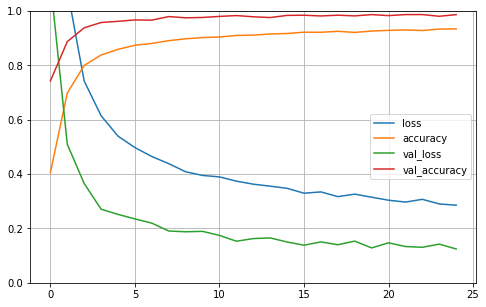

In [110]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [111]:
# Testing accuracy on the reserved test set
test = pd.read_csv('/content/MyDrive/MyDrive/archive/Test.csv')

labels = test["ClassId"].values
test_imgs = test["Path"].values

(1, 32, 32, 3)
5


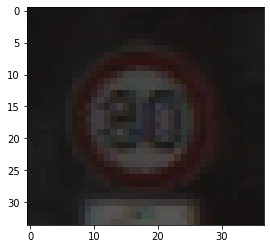

In [112]:

input_path='/content/MyDrive/MyDrive/archive/'
# How an image looks like
img_index = 56
image = Image.open(input_path + test_imgs[img_index])
img = image.resize((height,width))
img = np.array(img) / 255.
img = img.reshape(1, height, width, channels)

print(img.shape)
print(labels[img_index])
plt.imshow(image)

In [40]:
# Dictionary to map classes.
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
          }

In [113]:
# Prediction of this image
pred = model.predict_classes(img)[0]
print(pred)

sign = classes[pred]
print(sign)

5
Speed limit (80km/h)


In [114]:
pickle_in = open('/content/MyDrive/MyDrive/pickle/X_test.pickle',"rb")
X_test = pickle.load(pickle_in)

In [115]:
# Prediction of test set
pred = model.predict_classes(X_test)

#Accuracy with the test data
print("Accuracy score = %",100*accuracy_score(labels, pred))
end = time.time()
print("Time taken: ", round(end-start,5), "seconds")

Accuracy score = % 95.46318289786223
Time taken:  3335.78471 seconds
